In [38]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import os
import glob
from scipy.interpolate import griddata
import struct
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

## Interpolation NOAA TO SPEEDY

In [2]:
# Default pressure leves
pressure_levels = [1,2,3,5,7,9,11]
pressure_values = [925,850,700,500,300,200,100]
# Grids definition for SPEEDY and NOAA
X_speedy_long = np.linspace(360-3.75,0,96)
Y_speedy_lat = np.array("-87.159 -83.479 -79.777 -76.070 -72.362 -68.652 -64.942 -61.232 -57.521 -53.810 -50.099 -46.389 -42.678 -38.967 -35.256 -31.545 -27.833 -24.122 -20.411 -16.700 -12.989 -9.278 -5.567 -1.856 1.856 5.567 9.278 12.989 16.700 20.411 24.122 27.833 31.545 35.256 38.967 42.678 46.389 50.099 53.810 57.521 61.232 64.942 68.652 72.362 76.070 79.777 83.479 87.159".split(" "))
Y_speedy_lat = Y_speedy_lat.astype(np.float32)
X_noaa_long = np.linspace(360-2.5,0,144)
Y_noaa_lat = np.linspace(-90,90,73)
X_grid_noaa, Y_grid_noaa = np.meshgrid(X_noaa_long,Y_noaa_lat)

In [3]:
def ReadData(path, variable_name):
    '''
        input variables
            path          : path of the variable to be read
            variable_name : name of the variable
        output variable
            variable_array: 3-dimensional array with all the pressure levels of the given variable
    '''
    variable = Dataset(path,'r')
    variable_array = np.array(variable[variable_name][1,pressure_levels,:,:])
    return variable_array

def Interpoler(variable_grid, method = 'nearest'):
    '''
        input variables:
            variable_grid : variable in specific level to be spatially interpolated
            method        : method to use for the interpolation function (linear, nearest, cubic)
        output variable
            interp_noaa_speedy: speedy grid for certain level
    '''
    interp_noaa_speedy = griddata((X_grid_noaa.ravel(),Y_grid_noaa.ravel()), variable_grid.ravel()
                              , (X_speedy_long[None,:], Y_speedy_lat[:,None]), method=method)
    return interp_noaa_speedy

def relative2specific(T,RH,p):
    '''
    Parameters
    ----------
    T : Temperature in K.
    RH : Relative humidity in percentage [0,100].
    p : Preassure in mbar.

    Returns
    -------
    specific humidity (dimensionless)

    '''  
    T-=273.15
    p*=100
    RH/=100
    e_s=611.21*np.exp((18.687-T/234.5)*(T/(T+257.14)))
    e=e_s*RH
    w=287.058/461.5*e/(p-e)
    return w/(w+1)

In [4]:
folder = os.getcwd()+'/../Data/*'
files = glob.glob(folder)
files

['/Users/soniavalbuena/Desktop/Codes/AML/notebooks/../Data/uwnd.2020.nc',
 '/Users/soniavalbuena/Desktop/Codes/AML/notebooks/../Data/rhum.2020.nc',
 '/Users/soniavalbuena/Desktop/Codes/AML/notebooks/../Data/air.2020.nc',
 '/Users/soniavalbuena/Desktop/Codes/AML/notebooks/../Data/vwnd.2020.nc']

In [5]:
variables_list = list()
for file in files:
    variable_name = file.split("/")[-1].split(".")[0]
    variable_array = ReadData(file, variable_name)
    variable_levels = dict()
    for i in range(len(pressure_levels)):
        variable_level = variable_array[i,:,:]
        variable_levels[variable_name+"_"+str(pressure_levels[i])] = Interpoler(variable_level)
    variables_list.append(variable_levels)

In [6]:
variable_levels = dict()
variable_pressure = Dataset('/Users/soniavalbuena/Desktop/Codes/AML/notebooks/../pres.2020.nc','r')
variable_name = 'pres'
variable_array_pressure = np.array(variable_pressure[variable_name][1,:,:])
variable_levels[variable_name+"_1"] = Interpoler(variable_array_pressure)
variables_list.append(variable_levels)

In [7]:
variable_levels = dict()
for j,i in enumerate(pressure_levels):
    RH_data = variables_list[1]['rhum_'+str(i)]
    air_T_data = variables_list[2]['air_'+str(i)]
    pressure = pressure_values[j]
    #print(RH_data.shape, air_T_data.shape, pressure)
    variable_levels['shum_'+str(i)] = np.vectorize(relative2specific)(variables_list[2]['air_'+str(i)].copy(),
                                                                      variables_list[1]['rhum_'+str(i)].copy(),
                                                                      pressure)
variables_list.append(variable_levels)

In [8]:
component_names = list()
for i in range(len(variables_list)):
    print(list(variables_list[i].keys()))
    component_names.append(list(variables_list[i].keys()))

['uwnd_1', 'uwnd_2', 'uwnd_3', 'uwnd_5', 'uwnd_7', 'uwnd_9', 'uwnd_11']
['rhum_1', 'rhum_2', 'rhum_3', 'rhum_5', 'rhum_7', 'rhum_9', 'rhum_11']
['air_1', 'air_2', 'air_3', 'air_5', 'air_7', 'air_9', 'air_11']
['vwnd_1', 'vwnd_2', 'vwnd_3', 'vwnd_5', 'vwnd_7', 'vwnd_9', 'vwnd_11']
['pres_1']
['shum_1', 'shum_2', 'shum_3', 'shum_5', 'shum_7', 'shum_9', 'shum_11']


In [9]:
#variables_list[0]['uwnd_1'].shape

# Reshape is column major!!!

In [10]:
U_noaa = list()
V_noaa = list()
T_noaa = list()
SH_noaa = list()
p_noaa = list()

#uwnd
for level in component_names[0]: 
    #U_noaa.extend(np.reshape(variables_list[0][level], 96*48).tolist())
    U_noaa.extend(list(np.flip(np.flip(np.reshape(variables_list[0][level], (48,96))), axis = 1).flatten()))
#vwnd
for level in component_names[3]: 
    #V_noaa.extend(np.reshape(variables_list[3][level], 96*48).tolist())
    V_noaa.extend(list(np.flip(np.flip(np.reshape(variables_list[3][level], (48,96))), axis = 1).flatten()))
#air
for level in component_names[2]:
    #T_noaa.extend(np.reshape(variables_list[2][level], 96*48).tolist())
    T_noaa.extend(list(np.flip(np.flip(np.reshape(variables_list[2][level], (48,96))), axis = 1).flatten()))
#shum
for level in component_names[5]:
    #SH_noaa.extend(np.reshape(variables_list[5][level], 96*48).tolist())
    SH_noaa.extend(list(np.flip(np.flip(np.reshape(variables_list[5][level], (48,96))), axis = 1).flatten()))
#pres

p_noaa.extend(list(np.flip(np.flip(np.reshape(variables_list[4]['pres_1'], (48,96))), axis = 1).flatten()))

In [11]:
data_list = U_noaa + V_noaa + T_noaa + SH_noaa + p_noaa

In [12]:
fout = open('2020010106.grd', 'wb')
for i in data_list:
    fout.write(struct.pack('>f',i))
fout.close()

In [13]:
#fout = open('test3.grd', 'wb')
#for i in result_list:
#    fout.write(struct.pack('>f',i))
#fout.close()

In [14]:
#T_NOAA = np.reshape(T_noaa,(nlev,nlat,nlon))
#plt.contourf(T_NOAA[1,:,:])

In [15]:
#T = np.reshape(T_speedy,(nlev,nlat,nlon))
#plt.contourf(T[1,:,:])

In [16]:
#p_noaa_new = list(np.flip(np.flip(np.reshape(p_noaa, (48,96))), axis = 1).flatten())

In [17]:
#plt.contourf(np.rot90(np.reshape(p_noaa, (48,96)), k=2, axes=(0, 1)))
#plt.contourf(np.flip(np.flip(np.reshape(p_noaa, (48,96))), axis = 1))
#plt.contourf(np.flip(np.reshape(p_noaa, (48,96)) ,axis = (0,1)))
#plt.contourf(np.reshape(p_noaa, (48,96)))

In [18]:
#plt.contourf(np.reshape(p_speedy, (48,96)))

## LECTURE OF DATA

In [26]:
## SPEEDY Grid
nlon=96;
nlat=48;
nlev=7;
filename = '2020010106.grd'

In [27]:
infile = open(filename, "rb")    
data = np.fromfile(infile , '>f4')

In [28]:
U_speedy = list()
l = 0
for i in range(nlev*nlat*nlon):
    U_speedy.append(data[l])
    l += 1
V_speedy = list()
for i in range(nlev*nlat*nlon):
    V_speedy.append(data[l])
    l += 1
T_speedy = list()
for i in range(nlev*nlat*nlon):
    T_speedy.append(data[l])
    l += 1
SH_speedy = list()
for i in range(nlev*nlat*nlon):
    SH_speedy.append(data[l])
    l += 1
p_speedy = list()
for i in range(nlat*nlon):
    p_speedy.append(data[l])
    l += 1

In [96]:
def Error_plots(true_noaa, forcast_speedy):
    #true_noaa_array = np.reshape(true_noaa ,(96,48))
    #forcast_speedy_array = np.reshape(forcast_speedy ,(96,48))
    RMSE = mean_squared_error(true_noaa, forcast_speedy)
    MSE = mean_absolute_error(true_noaa, forcast_speedy)
    plt.figure(figsize=(16,8))
    ax1 = plt.subplot(131)
    ax1 = plt.contourf(true_noaa)
    ax1 = plt.title("TRUE NOAA")
    ax2 = plt.subplot(132)
    ax2 = plt.contourf(forcast_speedy)
    ax2 = plt.title("FORCAST SPEEDY")
    ax3 = plt.subplot(133)
    ax3 = plt.contourf(np.abs(true_noaa-forcast_speedy))
    ax3 = plt.title("ABS TRUE NOAA - FORCAST SPEEDY (ERRORS)")
    plt.colorbar()
    plt.show()
    print("RMSE:",RMSE, "MSE:", MSE)
    return RMSE, MSE

In [97]:
l_s = 0
forcast_speedy_U = np.empty([nlon, nlat,nlev])
for k in range(nlev):
    for j in range(nlat):
        for i in range(nlon):
            forcast_speedy_U[i,j,k] = data[l_s]
            l_s=l_s+1

l_n = 0
true_noaa_U = np.empty([nlon, nlat,nlev])
for k in range(nlev):
    for j in range(nlat):
        for i in range(nlon):
            true_noaa_U[i,j,k] = U_noaa[l_n]
            l_n=l_n+1

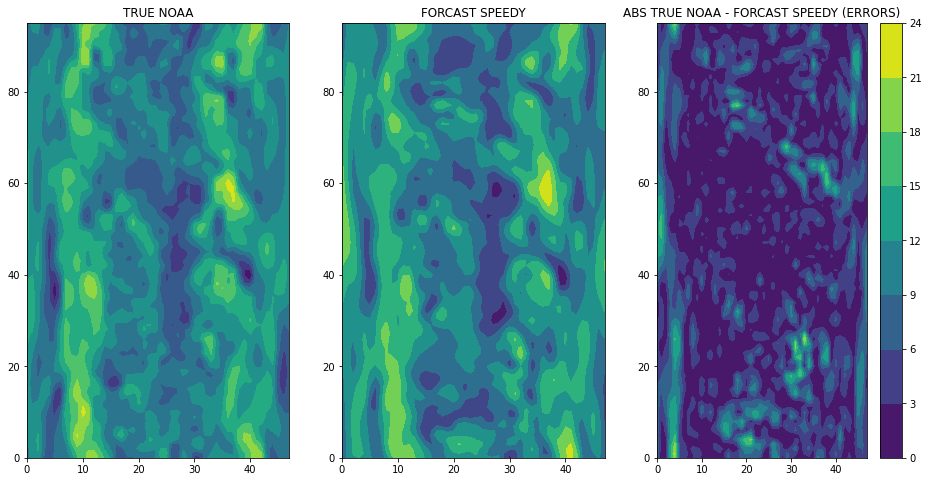

RMSE: 25.10413190812166 MSE: 3.7732475490401747


In [98]:
RMSE, MSE = Error_plots(true_noaa_U[:,:,0], forcast_speedy_U[:,:,0])

In [24]:
#fout = open('2020010100.grd', 'wb')
#for i in data_list:
#    fout.write(struct.pack('>f',i))
#fout.close()

In [25]:
'''l = 0
U = np.empty([nlon, nlat,nlev])
for k in range(nlev):
    for j in range(nlat):
        for i in range(nlon):
            U[i,j,k] = data[l]
            l=l+1
V = np.empty([nlon, nlat,nlev])
for k in range(nlev):
    for j in range(nlat):
        for i in range(nlon):
            V[i,j,k] = data[l]
            l=l+1
T = np.empty([nlon, nlat,nlev])
for k in range(nlev):
    for j in range(nlat):
        for i in range(nlon):
            T[i,j,k] = data[l]
            l=l+1
SH = np.empty([nlon, nlat,nlev])
for k in range(nlev):
    for j in range(nlat):
        for i in range(nlon):
            SH[i,j,k] = data[l]
            l=l+1
p = np.empty([nlon, nlat])
for j in range(nlat):
    for i in range(nlon):
        p[i,j] = data[l]
        l=l+1'''

'l = 0\nU = np.empty([nlon, nlat,nlev])\nfor k in range(nlev):\n    for j in range(nlat):\n        for i in range(nlon):\n            U[i,j,k] = data[l]\n            l=l+1\nV = np.empty([nlon, nlat,nlev])\nfor k in range(nlev):\n    for j in range(nlat):\n        for i in range(nlon):\n            V[i,j,k] = data[l]\n            l=l+1\nT = np.empty([nlon, nlat,nlev])\nfor k in range(nlev):\n    for j in range(nlat):\n        for i in range(nlon):\n            T[i,j,k] = data[l]\n            l=l+1\nSH = np.empty([nlon, nlat,nlev])\nfor k in range(nlev):\n    for j in range(nlat):\n        for i in range(nlon):\n            SH[i,j,k] = data[l]\n            l=l+1\np = np.empty([nlon, nlat])\nfor j in range(nlat):\n    for i in range(nlon):\n        p[i,j] = data[l]\n        l=l+1'